In [1]:
# Env using Python 3.10.14
# pip install notebook==5.7.5

# the keras libraries
# pip install tensorflow Version: 2.17.0
import tensorflow as tf

from tensorflow.python.keras import models, layers

# Version: 3.4.1
from tensorflow import keras

# pip install keras-tuner
import keras_tuner as kt

In [7]:
# other libraries
import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt

# use for splitting the test and train data
from sklearn.model_selection import train_test_split

# for the creation of the cartesian product grid
from itertools import product

# for the timing of each test
import time
import datetime

In [44]:
import math
import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score

In [4]:
# the data tools module
import data_tools as dt
dh = dt.Data_Handling(output_size=5)

In [8]:
# set the paths to load the processed data
CURRENT_DIR = os.curdir
label_path = f'{CURRENT_DIR}/data/mitdb_labels_reduced.npy'
data_path = f'{CURRENT_DIR}/data/mitdb_data_reduced.npy'

# get the data
dh.load_data(label_path=label_path, data_path=data_path)

# split into train and test sets
dh.split_data(split=0.2)

print(dh.X_train.shape, dh.X_test.shape)

Loaded files of size:
Images: (14190, 281, 362, 1)
Labels: (14190,)
(11352, 281, 362, 1) (2838, 281, 362, 1)


In [10]:
dh.split_data(split=0.2)
print(dh.X_train.shape, dh.X_test.shape)

(11352, 281, 362, 1) (2838, 281, 362, 1)


# Basic conv net to achieve statistical significance

In [18]:
def build_basic_model(shape, output_size, callbacks):
    '''
    build a model of single layer Conv2d using minimum size
    
    parameters:
        shape (tuple) the shape of the test data
        output_size (int) the number of classes to be modelled
        callbacks (list of keras callbacks) callbacks such as early stopping
        
    returns:
        model (keras model) a compiled keras model
    '''
    inputs = keras.Input(shape=shape)   
    x = keras.layers.Conv2D(filters=2, kernel_size=3, activation="relu")(inputs) 
    x = keras.layers.Flatten()(x)
    
    outputs = keras.layers.Dense(output_size, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    # compile the model
    model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    return model

In [19]:
# build the basic model and save the weights for use thorughout the testing 
model = build_basic_model(dh.shape, dh.output_size, callbacks=[])
# model.save_weights('../weights/basic.weights.h5')

In [20]:
# set the params
max_epochs = 50
vaidation_split = 0.2
batch_size = 256

# create the callbacks
metric = 'val_loss'
checkpoint_path = 'checkpoint_path.keras'

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor=metric, 
        patience=3
    )
]

In [29]:
def get_best_epoch(history, metric):
    '''
    find the best epoch for the given metric. eg if 'accuracy' find the maximum value
    in the history list
    
    parameters:
         metric (string) the metric used for training
         history (dict) the history returned from the model fit
         
     returns:
         best_idx (int) the index of the best result in the list
    '''

    if metric in ['accuracy', 'val_accuracy']:
        best_idx = np.argmax(history[metric])
    elif metric in ['loss', 'val_loss']:
        best_idx = np.argmin(history[metric])
    else:
        raise ValueError(f'Metric {metric} not supported')

    return best_idx

In [22]:
# build fresh model
basic_model = build_basic_model(dh.shape, dh.output_size, callbacks)
# basic_model.load_weights('../weights/basic.weights.h5')

# fit to the taining data
history = basic_model.fit(
    dh.X_train, 
    dh.y_train, 
    epochs=max_epochs, 
    validation_split=vaidation_split, 
    batch_size=batch_size, 
    callbacks=[callbacks]
)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 389ms/step - accuracy: 0.3030 - loss: 29389.5391 - val_accuracy: 0.1656 - val_loss: 9778.1377
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.3278 - loss: 9686.4893 - val_accuracy: 0.1656 - val_loss: 3636.2600
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 369ms/step - accuracy: 0.4798 - loss: 2762.2000 - val_accuracy: 0.8683 - val_loss: 121.8922
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 383ms/step - accuracy: 0.7959 - loss: 356.4316 - val_accuracy: 0.9080 - val_loss: 47.2519
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 372ms/step - accuracy: 0.9111 - loss: 36.5685 - val_accuracy: 0.9221 - val_loss: 14.4304
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 382ms/step - accuracy: 0.9524 - loss: 5.9002 - val_accuracy: 0.9207 - val_loss: 8.0248
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 384ms/step - accuracy: 0.9838 - loss: 0.8730 - val_accuracy: 0.9229 - val_loss: 7.5007
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 377ms/step - accuracy: 0.9872 - 

In [30]:
# using the epoch as per the early stopping callback above
# get the index of the lowest recorded loss function (+ 1 to account for 0 idx)
best_epoch = get_best_epoch(history.history, metric) + 1

# build and train a fresh model for evaluation
basic_model = build_basic_model(dh.shape, dh.output_size, callbacks=[])
# basic_model.load_weights('../weights/my_model_weights.h5')
# fit model on the entire training set by removing the validation_split param
basic_model.fit(
    dh.X_train, 
    dh.y_train, 
    epochs=best_epoch, 
    batch_size=batch_size, 
)

Epoch 1/8
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 331ms/step - accuracy: 0.7683 - loss: 0.7258
Epoch 2/8
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 329ms/step - accuracy: 0.9970 - loss: 0.0170
Epoch 3/8
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 329ms/step - accuracy: 0.9999 - loss: 0.0011
Epoch 4/8
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 331ms/step - accuracy: 1.0000 - loss: 1.0637e-04
Epoch 5/8
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 334ms/step - accuracy: 1.0000 - loss: 1.2360e-05
Epoch 6/8
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 346ms/step - accuracy: 1.0000 - loss: 5.2912e-06
Epoch 7/8
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 340ms/step - accuracy: 1.0000 - loss: 2.5190e-06
Epoch 8/8
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 349ms/step - accuracy: 1.0000 - loss: 1.7244e-06


In [32]:
# evaluate performance on the unseen test data to see whether the basic model can beat 
# a the statistical significance calculated in the workbook [WORKBOOK]
res = basic_model.evaluate(
    dh.X_test, 
    dh.y_test, 
    batch_size=batch_size, 
    return_dict=True
)

res

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.8955 - loss: 0.8672


{'accuracy': 0.8995771408081055, 'loss': 0.842587947845459}

In [58]:
def get_prediction_results(model, X, y):
    '''
    run model on the test set of unseen data
    
    parameters:
        model (trained keras model)
        X_test (np.array) the test data to classify
        y_test (np.array) the test labels to used in the results
        
    returns:
        cm (array) confusion matrix
        recall (float) the recall value
        precision (float) the precision value
    '''
    
    labels = [0,1,2,3,4]
    # run the model against the test data
    y_pred = model.predict(X) 
    # convert the predictions to integers representing the classes
    y_pred_labels = np.argmax(y_pred, axis = 1)
    # create a confution matrix 
    cm = confusion_matrix(y, y_pred_labels, labels=labels)
    # get the recall and precision scores
    recall = recall_score(y, y_pred_labels, average='macro')
    precision = precision_score(y, y_pred_labels, average='macro')
    
    return cm, recall, precision

cm, rec, prec = get_prediction_results(basic_model, dh.X_test, dh.y_test)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


/Users/jodywright/anaconda3/envs/ml3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


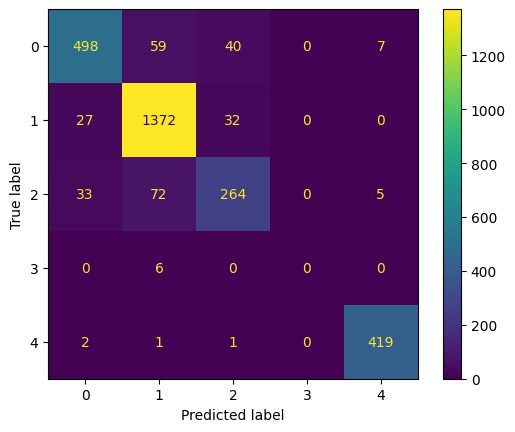

In [59]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[0,1,2,3,4]

)

disp.plot()
plt.show()

### Notes
The basic model of 1 conv2d with 2 filters acheived the following evaluation results when trained using a batch size of 256:
- accuracy 0.8995
- val_loss 0.8425  
The early stopping callback even found a point of overfitting after the 9th epoch.  

For testing the optimizers, a level playing field is created by saving the weights from an initial model. This needed repeating for the two layers model since the layer archetecture must be an exact match for that of the new model using the weights.  



In [27]:
p = np.argmax(pred, axis = 1)
r =dh.y_test
print(p,r)

[4 1 1 ... 4 1 2] [4 1 1 ... 4 1 2]


In [33]:
p = model.predict(dh.X_test)
p = np.argmax (p)
y_test=np.argmax(dh.y_test)

result = confusion_matrix(y_test, y_prediction , normalize='pred')
print(result)

89/89 [==============================] - 2s 17ms/step


NameError: name 'confusion_matrix' is not defined

In [ ]:
model.evaluate(X_test, y_test, batch_size=batch_size)

In [ ]:
model.history.history

## Grid search using keras library functinon

In [241]:
class HyperModel(kt.HyperModel):
    
    def __init__(self, num_classes, shape, filter_step=16, lr_step=0.1, weights=None):

            self.__num_classes = num_classes
            self.__shape = shape
            self.__filter_step = filter_step
            self.__lr_step = lr_step
            self.__weights = weights
            
    def build(self, hp):

        filters_1 = hp.Int(name="filters_1", min_value=16, max_value=32, step=self.__filter_step) 
        filters_2 = hp.Int(name="filters_2", min_value=32, max_value=64, step=self.__filter_step)
        # allows a zero setting 
        rate_1 = hp.Float(name="rate_1", min_value=0.2, max_value=0.5, step=self.__lr_step)
        
        inputs = keras.Input(shape=self.__shape)
        x = keras.layers.Conv2D(filters=filters_1, kernel_size=3, activation="relu")(inputs) 
        x = keras.layers.MaxPooling2D(pool_size=2)(x)
        x = keras.layers.Dropout(rate=rate_1)(x)
        x = keras.layers.Conv2D(filters=filters_2, kernel_size=3, activation="relu")(x) 
        x = keras.layers.MaxPooling2D(pool_size=2)(x)

        x = keras.layers.Flatten()(x)
        
        outputs = keras.layers.Dense(self.__num_classes, activation="softmax")(x)
        model = keras.Model(inputs=inputs, outputs=outputs)
        
        learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        
        model.compile(
            optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"])
        
        # to ensure a level playing field between optimisers
        if self.__weights:
            model.load_weights('../weights/opt_test_weights.h5')
        
        return model

In [240]:
# get a set of initialized weights for the model
hp1 = kt.HyperParameters()
filter_step=8

hp1.Int(name="filters_1", min_value=16, max_value=32, step=filter_step) 
hp1.Int(name="filters_2", min_value=16, max_value=64, step=filter_step)
rate_1 = hp1.Float(name="rate_1", min_value=0, max_value=0.5, step=0.1)
hp1.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

hpm = HyperModel(num_classes=dh.output_size, shape=dh.shape, filter_step=16)
model = hpm.build(hp1)
weights_path = '../weights/opt_test_weights.h5'
model.save_weights(weights_path)

model.save('../models/untrained.keras')
# del model
# load_model('../models/untrained.keras')

In [111]:
class Tuner_Timer:
    
    def __init__(self):
        self.__start = None
        self.__end = None
        self.__duration = None
#         self.__results = {}
#         self.__tuners = []
#         self.__common_params = common_params
#         self.__callbacks = []
        
    def add_tuner(self, tuner):
        self.__tuners.append(tuner)
        
    def start(self):
        '''
        start the timer 
        '''
        self.__start = time.time()
        
    def stop(self):
        '''
        stop the timer and format the duration
        '''
        self.__end = time.time()
        self.__duration = self.__end - self.__start
        duration_string = time.strftime('%H:%M:%S', time.gmtime(self.__duration))

        return duration_string

In [112]:
def save_best_result(results_dict, results, tuner):

#     if tuner.project_name in results_dict.keys():
        
#         results_dict[tuner.project_name].update(results)
# #         print(results)
#     else:
#         results_dict[tuner.project_name] = results
        
    #save the current result to file
    f = open(f"{tuner.directory}/results.json", "w")

    json.dump(results, f, indent = 6)

    f.close()

In [179]:
def run_tuner(timer, tuner, batch_size, max_epochs, callbacks):
        '''
        run a given tuner saving the best parameter configuration to a timer object
        along with the total duration of the optimizer's run

        params:
            timer (Tuner_Timer) the timer used for recording results
            tuner (keras.Tuner) the current tuner under test 
            batch_size (int) batch for training 
            max_epochs (int) the maximum number of epochs to run if not stopped by early stopping
            callbacks (keras.callbacks) for early stopping
        '''
        # start timer
        print(f'Running optimizer {tuner.project_name}')
        timer.start()
        # the tuner will save results to the directory specified in the tuner constructor
        tuner.search(
            dh.X_train, dh.y_train,
            batch_size=batch_size,
            epochs=max_epochs,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )

        # get the best performing hyper parameter set
        best_hps = tuner.get_best_hyperparameters()[0].values
        # stop timing and get the duration
        test_duration = timer.stop()
        
        return {'duration':test_duration, 'best_params':best_hps}

In [114]:
def retrain_and_evaluate(tuner):
    # get the object hp to rebuild a fresh model
    best_hps = tuners[0].get_best_hyperparameters()[0]
    # build a fresh model for retraining in order to find the point of overfitting
    model = hypermodel.build(best_hps)
    print('Finding best epoch')
    model.fit(dh.X_train[:1000], dh.y_train[:1000],
                batch_size=batch_size,
                epochs=max_epochs,
                validation_split=0.2,
                callbacks=callbacks,)

    # find best epoch since there seems no way to find this in the tuner
    best_epoch = np.argmin(model.history.history['val_accuracy'])
    # rebuild fresh model
    print(f'\nRetraining to best epoch: {best_epoch}')
    model = hypermodel.build(best_hps)
    # reterain on the entire set for the best epoch
    model.fit(dh.X_train, dh.y_train,
                batch_size=batch_size,
                epochs=best_epoch,)
    
    print('\nEvaluating model')
    loss, accuracy = model.evaluate(dh.X_test, dh.y_test)
    return loss, accuracy, best_epoch

In [253]:
hypermodel = HyperModel(num_classes=dh.output_size, shape=dh.shape, filter_step=16)
now = str(datetime.datetime.now())[5:10]

directory = f"start-{now}"
print(directory)
metrics = "val_loss"

common_params = {
#     'hypermodel': hypermodel, 
    'objective': metrics, 
    'executions_per_trial':1,
    'directory':directory,
    'tuner_id':'test_03',
    'overwrite':False,
}

callbacks = [
    keras.callbacks.EarlyStopping(monitor=metrics, patience=3),
]

start-08-28


In [254]:
batch_size = 128
max_epochs = 30

timer = Tuner_Timer()
best_results = {}
tuners = []

In [257]:
# RANDOM
tuners.append(kt.RandomSearch(build_optimizer_model, project_name='random', max_trials=40, **common_params))

# HYPERBAND
tuners.append(kt.Hyperband(build_optimizer_model, project_name='hyperband', factor=3, hyperband_iterations=1, **common_params))

# BAYES
tuners.append(kt.BayesianOptimization(build_optimizer_model, project_name='bayes', **common_params))

# GRID
tuners.append(kt.GridSearch(build_optimizer_model, project_name='grid', **common_params))

In [258]:
# run all optimizers
for seed, tuner in enumerate(tuners):
    # set seed for a level playing field between optimisers
#     tf.keras.utils.set_random_seed(seed)
    # run the optimizer
    best_result = run_tuner(timer, tuner, batch_size, max_epochs, callbacks)
    
#     # add best params to result dict and save current dict to file
#     save_best_result(best_results, best_result, tuner)
    if tuner.project_name in best_results.keys():
        
        best_results[tuner.project_name].update(best_result)
#         print(results)
    else:
        best_results[tuner.project_name] = best_result
    
    loss, accuracy, best_epoch = retrain_and_evaluate(tuners[0])
    
    best_results[tuner.project_name]['loss'] = loss
    best_results[tuner.project_name]['accuracy'] = accuracy
    #convert from int64 to make serializable
    best_results[tuner.project_name]['best_epoch'] = int(best_epoch)
    
     #save the current result to file
    f = open(f"{tuner.directory}/results.json", "w")

    json.dump(best_results, f, indent = 6)

    f.close()
    
    print(f'Loss: {loss}\tAccuracy: {accuracy}')
    

Trial 27 Complete [00h 36m 00s]
val_loss: 0.15532536804676056

Best val_loss So Far: 0.15532536804676056
Total elapsed time: 13h 23m 27s
Finding best epoch
Epoch 1/30
7/7 [==============================] - 14s 2s/step - loss: 1911.9928 - accuracy: 0.2725 - val_loss: 147.0729 - val_accuracy: 0.5250
Epoch 2/30
7/7 [==============================] - 12s 2s/step - loss: 787.3993 - accuracy: 0.3200 - val_loss: 274.2293 - val_accuracy: 0.2200
Epoch 3/30
7/7 [==============================] - 12s 2s/step - loss: 566.2479 - accuracy: 0.3525 - val_loss: 280.5002 - val_accuracy: 0.5250
Epoch 4/30
7/7 [==============================] - 13s 2s/step - loss: 726.5581 - accuracy: 0.3063 - val_loss: 295.4773 - val_accuracy: 0.1250

Retraining to best epoch: 3
Epoch 1/3
89/89 [==============================] - 176s 2s/step - loss: 384.8629 - accuracy: 0.3375
Epoch 2/3
89/89 [==============================] - 167s 2s/step - loss: 63.5409 - accuracy: 0.4828
Epoch 3/3
89/89 [==============================

In [259]:
best_results

{'random': {'duration': '13:12:02',
  'best_params': {'filters_1': 24,
   'rate_1': 0.30000000000000004,
   'learning_rate': 0.0001,
   'filters_2': 32},
  'loss': 1.2720849514007568,
  'accuracy': 0.6578576564788818,
  'best_epoch': 3},
 'hyperband': {'duration': '02:28:52',
  'best_params': {'filters_1': 32,
   'rate_1': 0.2,
   'learning_rate': 0.001,
   'tuner/epochs': 2,
   'tuner/initial_epoch': 0,
   'tuner/bracket': 4,
   'tuner/round': 0},
  'loss': 0.8689003586769104,
  'accuracy': 0.7431289553642273,
  'best_epoch': 3},
 'bayes': {'duration': '04:25:49',
  'best_params': {'filters_1': 24, 'rate_1': 0.4, 'learning_rate': 0.0001},
  'loss': 0.20684757828712463,
  'accuracy': 0.9467934966087341,
  'best_epoch': 12},
 'grid': {'duration': '13:23:26',
  'best_params': {'filters_1': 16, 'rate_1': 0.2, 'learning_rate': 0.0001},
  'loss': 0.9508249163627625,
  'accuracy': 0.7847075462341309,
  'best_epoch': 3}}

In [ ]:
tuners[0].results_summary(1)

In [116]:

now = datetime.datetime.now()
str(now)[:10]

'2024-08-28'

In [245]:
def build_untrained_model():

        inputs = keras.Input(shape=dh.shape)
        x = keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs) 
        x = keras.layers.MaxPooling2D(pool_size=2)(x)
        x = keras.layers.Dropout(rate=0.1)(x)
        x = keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x) 
        x = keras.layers.MaxPooling2D(pool_size=2)(x)

        x = keras.layers.Flatten()(x)
        
        outputs = keras.layers.Dense(dh.output_size, activation="softmax")(x)
        model = keras.Model(inputs=inputs, outputs=outputs)
   
        return model

# build a model and save its weights for use throughout
model = build_untrained_model()
model.save_weights('../weights/untrained.h5')

In [256]:
def build_optimizer_model(hp):
    
    model = build_untrained_model()
    model.load_weights('../weights/untrained.h5')
    
    model.layers[0].filters = hp.Int(name="filters_1", min_value=16, max_value=32, step=8)
    model.layers[2].rate = hp.Float(name="rate_1", min_value=0.2, max_value=0.5, step=0.1)
    model.layers[3].filters = hp.Int(name="filters_1", min_value=16, max_value=32, step=8)
    
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(
            optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"])
    
    return model

In [251]:
# common_params = {
#     'objective': metrics, 
#     'executions_per_trial':1,
#     'directory':directory,
#     'tuner_id':'test_03',
#     'overwrite':False,
# }

# tuner= kt.RandomSearch(
#     build_opt_model,
#     project_name='test_random', 
#     max_trials=4, 
# )

# tuner.search(
#             dh.X_train, dh.y_train,
#             batch_size=batch_size,
#             epochs=max_epochs,
#             validation_split=0.2,
#             callbacks=callbacks,
#             verbose=1
#         )


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
24                |24                |filters_1
0.4               |0.4               |rate_1
0.01              |0.01              |learning_rate

Epoch 1/30
71/71 [==============================] - 235s 3s/step - loss: 1917.2975 - accuracy: 0.3762 - val_loss: 1.5073 - val_accuracy: 0.2162
Epoch 2/30
 4/71 [>.............................] - ETA: 4:07 - loss: 1.3196 - accuracy: 0.5410

KeyboardInterrupt: 

[cite]  
The Hyperband tuning algorithm uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model. This is done using a sports championship style bracket. The algorithm trains a large number of models for a few epochs and carries forward only the top-performing half of models to the next round. Hyperband determines the number of models to train in a bracket by computing 1 + logfactor(max_epochs) and rounding it up to the nearest integer.

## Redundant code

In [ ]:
d = {
     0:
      {'hyperband':
       {'r1':100,'r2':150},
      'bayes':
       {'r1':100,'r2':150}
      },
      1:
      {'hyperband':
       {'r1':100,'r2':150},
      'bayes':
       {'r1':100,'r2':150}
      }
     }
    
d[2] = {"hyperband":{}}
d[2]['hyperband'] = {'r1':999,'r2':999}
d

### Results
Error "BiasGrad requires tensor size <= int32 max" with batch 256  
https://stackoverflow.com/questions/60414562/how-to-solve-the-biasgrad-requires-tensor-size-int32-max-invalidargumenterr